# Inicializacion e imports

In [1]:
%reload_ext autoreload
%autoreload 2


HOST = "http://127.0.0.1:3000/"

PROJECT_NAME = "NPF Detector"
EXPERIMENT_NAME = "test"
EXPERIMENT_DESCRIPTION = "Refactor test"


import src.visualization.visualize as viz
import src.HTK.htktools as htkt
import src.HTK.scripts as scripts

# Inicializo Verta

In [2]:
from verta import Client

client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run(desc=EXPERIMENT_DESCRIPTION)

connection successfully established
set existing Project: NPF Detector from personal workspace
set existing Experiment: test
created new ExperimentRun: Run 2270515977046957704296


# Preparo los datos

In [3]:
n_test, n_train = htkt.setup_data(convert_to_dndlogdp=False, data_version='1')

run.log_observation('number_of_test_files', n_test)
run.log_observation('number_of_train_files', n_train)
run.log_hyperparameters({'convert_to_dndlogdp': False})

INFO:root:Converting raw files to HTK format ...
INFO:root:Data version: 1
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Generating script (.scp) files...
INFO:root:Adding deltas and acelerations...


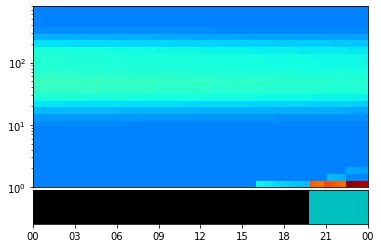

In [4]:
thresholds = {'nuc_threshold': 0.15,       # 1/cm3/10min
             'pos_vol_threshold': 200,       # 1/m3^3/10min
             'neg_vol_threshold': -5000         # 1/cm3/10min
             }      # 1/m3^3/10min

#scripts.make_labels(thresholds, how='event-noevent', data_version='1')
viz.evaluate_hyperparameter_for_label('1-20160512.h5', thresholds)
#run.log_hyperparameters(thresholds)

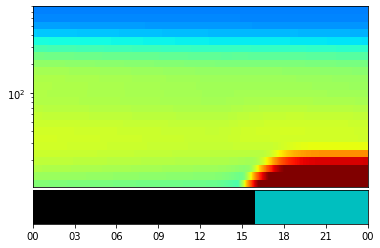

In [175]:
thresholds = {'nuc_threshold': 0.15,       # 1/cm3/10min
             'pos_vol_threshold': 200,       # 1/m3^3/10min
             'neg_vol_threshold': -5000         # 1/cm3/10min
             }  
viz.evaluate_hyperparameter_for_label('2-20160512.h5', thresholds)

## Inicializo el modelo de Markov

In [5]:
model = htkt.initialize(how='HCompV')

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HCompV -C ../src/HTK/misc/config -S ../data/interim/train.scp -M ../models/hmm/0 -T 1 -f 0.1 -m ../src/HTK/misc/proto
Calculating Fixed Variance
  HMM Prototype: ../src/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: ../models/hmm/0
  ERROR [+2050]  CheckData: Vector size in ../data/interim/train_D_A/20170324[84] is incompatible with hmm ../src/HTK/misc/proto[75]
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HCompV


FileNotFoundError: [Errno 2] No such file or directory: '../models/hmm/0/proto'

Edito el el archivo hmmdefs y le agrego los modelos creados con HInit

### Estimo los parametros

In [62]:
most_trained_model=0
n = 3

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 150.0,# 50.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_1_gaussian', '../models/hmm/' + str(most_trained_model), overwrite=True)

Pruning-Off

Pruning-Off

Pruning-Off

upload complete (model_1_gaussian)


### Evaluo

In [63]:
htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(1),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/3/macros -H ../models/hmm/3/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_1 ../src/HTK/misc/dict ../src/HTK/misc/monophones 



In [64]:
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '-p',
                   '../src/HTK/misc/monophones',
                   '../data/interim/results_1'])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_1_gaussian', r['WORD_Corr'])

====================== HTK Results Analysis =======================
  Date: Mon Aug 17 19:17:44 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_1
------------------------ Overall Results --------------------------
SENT: %Correct=81.37 [H=83, S=19, N=102]
WORD: %Corr=81.76, Acc=70.95 [H=121, D=24, S=3, I=16, N=148]
------------------------ Confusion Matrix -------------------------
       e   n 
           e  Del [ %c / %e]
   e  18   3   13 [85.7/2.0]
  ne   0  103  11
Ins    2  14



ValueError: metric with key correct_1_gaussian already exists; consider using observations instead

### Agrego la transicion entre los estados 2 y 4 para el estado estaiconario

In [14]:
htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/add_equ_24_trans.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

### Edito el modelo, ahora uso 2 gaussianas

In [15]:
#most_trained_model = 3
print("Modelo inicial:", most_trained_model)
number_of_gaussians = 2

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, #150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

print("Modelo Final:", most_trained_model)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_2gaussians', r['WORD_Corr'])

Modelo inicial: 4

Pruning-Off

Pruning-Off

Pruning-Off

upload complete (model_2_gaussian)
Modelo Final: 8
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/8/macros -H ../models/hmm/8/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_2 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Mon Aug 17 13:52:50 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_2
------------------------ Overall Results --------------------------
SENT: %Correct=8.57 [H=9, S=96, N=105]
WORD: %Corr=95.49, Acc=15.79 [H=127, D=2, S=4, I=106, N=133]



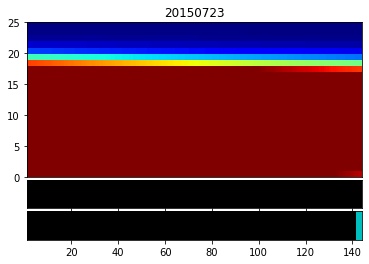

In [38]:
viz.evaluate_results(n_gaussians=1)

### Edito el modelo, ahora uso 4 gaussianas

In [40]:
#most_trained_model = 6
number_of_gaussians = 4

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
print("Modelo final:", most_trained_model)    
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_4_gaussians', r['WORD_Corr'])

Modelo inicial: 12

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 16
upload complete (model_4_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/16/macros -H ../models/hmm/16/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_4 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Mon Aug 17 13:54:53 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_4
------------------------ Overall Results --------------------------
SENT: %Correct=66.67 [H=70, S=35, N=105]
WORD: %Corr=94.74, Acc=67.67 [H=126, D=3, S=4, I=36, N=133]



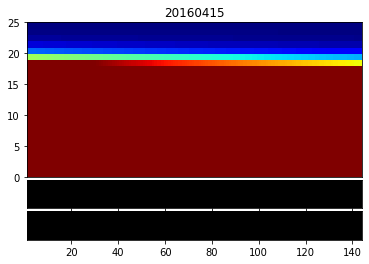

In [56]:
viz.evaluate_results(n_gaussians=4)

### Edito el modelo, ahora uso 8 gaussianas

In [382]:
#most_trained_model = 9
number_of_gaussians = 8

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            #'-p', 0,
            #'-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_8_gaussians', r['WORD_Corr'])

Modelo inicial: 17

Pruning-Off

Pruning-Off

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 22
upload complete (model_8_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/22/macros -H ../models/hmm/22/hmmdefs -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_8 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 23 12:58:26 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_8
------------------------ Overall Results --------------------------
SENT: %Correct=62.11 [H=100, S=61, N=161]
WORD: %Corr=64.69, Acc=50.77 [H=251, D=120, S=17, I=54, N=388]



### Edito el modelo, ahora uso 16 gaussianas

In [457]:
#most_trained_model = 22
number_of_gaussians = 16

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '-p',
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_16_aussians', r['WORD_Corr'])

Modelo inicial: 22

Pruning-Off

Pruning-Off

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 28
upload complete (model_16_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/28/macros -H ../models/hmm/28/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_16 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 23 16:16:49 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_16
------------------------ Overall Results --------------------------
SENT: %Correct=59.63 [H=96, S=65, N=161]
WORD: %Corr=65.98, Acc=48.20 [H=256, D=112, S=20, I=69, N=388]
------------------------ Confusion Matrix -------------------------
       e   n   c   c   d 
       q   u   o   o   e 
       u   c   a   n   p  Del [ %c / %e]
 equ  202  0   2  11   0   44 [94.0/3.4]
 nuc

ValueError: metric with key correct_16_aussians already exists; consider using observations instead

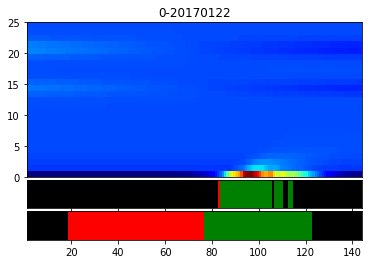

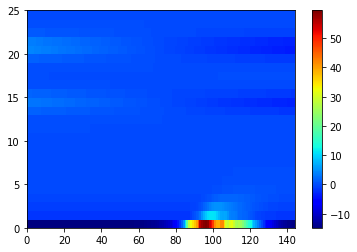

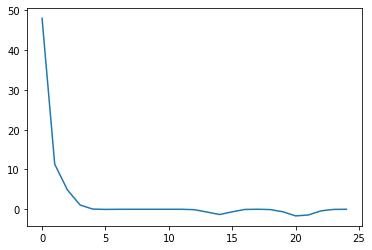

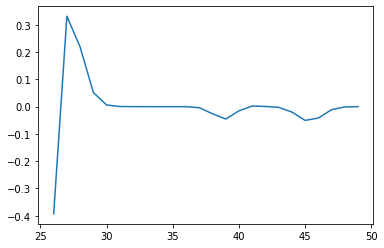

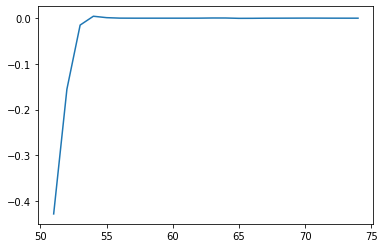

In [448]:
viz.evaluate_results('0-20170122', n_gaussians=16)
viz.testDA_file('0-20170122', sample=100)

### Edito el modelo, ahora uso 32 gaussianas

In [401]:
#most_trained_model = 15
number_of_gaussians = 32

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_32_gaussians', r['WORD_Corr'])

Modelo inicial: 28
 WARNING [-2637]  HeaviestMix: mix 8 in con has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 15 in con has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 34
upload complete (model_32_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/34/macros -H ../models/hmm/34/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_32 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 23 13:00:51 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec :

### Edito el modelo, ahora uso 64 gaussianas

In [402]:
#most_trained_model = 18
number_of_gaussians = 64

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_64_gaussians', r['WORD_Corr'])

Modelo inicial: 34
 WARNING [-2637]  HeaviestMix: mix 3 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 4 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 6 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 7 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 11 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 12 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 13 in coa has 

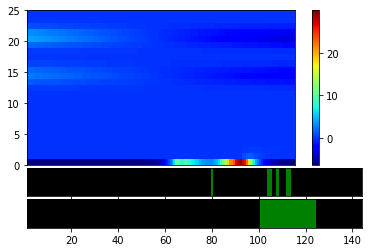

In [409]:
viz.evaluate_results(n_gaussians=64)

### Edito el modelo, ahora uso 128 gaussianas

In [410]:
#most_trained_model = 21
number_of_gaussians = 128

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_128_gaussians', r['WORD_Corr'])

Modelo inicial: 40
 WARNING [-2637]  HeaviestMix: mix 1 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 5 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 7 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 9 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 10 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 11 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 13 in coa has 

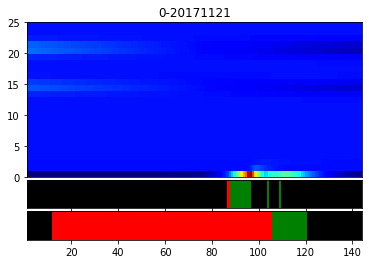

In [465]:
viz.evaluate_results(n_gaussians=128)

### Edito el modelo, ahora uso 256 gaussianas

In [162]:
#most_trained_model = 24
number_of_gaussians = 256

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_256_gaussians', r['WORD_Corr'])

Modelo inicial: 24
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/24/macros -H ../models/hmm/24/hmmdefs -M ../models/hmm/25 ../src/HTK/misc/pow256.hed ../src/HTK/misc/monophones
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 27
upload complete (model_256_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_256 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Mon Jul 20 16:36:28 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/res

### Edito el modelo, ahora uso 512 gaussianas

In [172]:
most_trained_model = 27
number_of_gaussians = 512

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            '-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_512_gaussians', r['WORD_Corr'])

Modelo inicial: 27
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -M ../models/hmm/28 ../src/HTK/misc/pow512.hed ../src/HTK/misc/monophones
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 30
upload complete (model_512_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/30/macros -H ../models/hmm/30/hmmdefs -p 0 -s 5 -A -T 1 -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_512 ../src/HTK/misc/dict ../src/HTK/misc/monophones 
Read 5 physical / 5 logical HMMs
Read lattice with 8 nodes / 16 arcs
Created network with 15 nodes / 23 links
File: ../data/interim/test_D_A/0-20170720
equ dep equ  ==  [144 fra

ValueError: metric with key correct_512_gaussians already exists; consider using observations instead

In [462]:
viz.evaluate_results(n_gaussians=512)

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/results_512'

### Evaluo algunos casos reales

In [140]:
htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/e',
            '-H', '../models/hmm/' + str(most_trained_model) + '/ne',
            '-p', 1,
            '-s', 5,
            '-A',
            '-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/external/real_test_files/test_real_data.scp',
            '-i', '../data/interim/results_real_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_real_' + str(number_of_gaussians)])

# for k,v in r.items():
#     run.log_observation(k,v)
    
# run.log_metric('correct_512_gaussians', r['WORD_Corr'])

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/7/e -H ../models/hmm/7/ne -p 1 -s 5 -A -T 1 -w ../src/HTK/misc/wdnet -S ../data/external/real_test_files/test_real_data.scp -i ../data/interim/results_real_2 ../src/HTK/misc/dict ../src/HTK/misc/monophones 
Read 2 physical / 2 logical HMMs
Read lattice with 5 nodes / 7 arcs
Created network with 9 nodes / 11 links
File: ../data/external/real_test_files/DM20171110
No tokens survived to final node of network
File: ../data/external/real_test_files/DM20171113
No tokens survived to final node of network
File: ../data/external/real_test_files/DM20171115
No tokens survived to final node of network

No transcriptions found



In [29]:
viz.real_file('DM20171115')

FileNotFoundError: [Errno 2] No such file or directory: '../data/external/real_test_files/DM20171115'